<b> Functions <b>

In [2]:
from qutip import *
import pylab as py
import numpy as np
import matplotlib.pyplot as plt


def heaviside(x):
    if x >= 0 :
        return 1
    if x < 0 :
        return 0
    
def nega(rho, subsys):
    
    #create mask which counts the number of possible subsystems
    x = [0 for i in rho.dims[0]]
   
    #assigns a 1 in the position of the subsystem for which we want to compute the negativity
    x[subsys] = 1
        
    #takes partial transpose with respect to subsys x
    rho_pt = partial_transpose(rho, x)
    
    #finds eivenvalues of pt matrix
    eig = rho_pt.eigenenergies()
    
    #finds abs value of the eigenvalues
    abs_eig = abs(eig)
    
    negat = 0 #initialize value of negativity
    
    #takes the difference 
    diff = (abs_eig - eig)
    
    
    #computes negativity
    for el in diff:
        negat += el

    
    return negat

<b> Parameters <b>

In [5]:
#transition frequency
wc = 10**(9)*2*np.pi*4.343 # frequency of the cavity photons
wa = 10**(9)*2*np.pi*5.439  # transition frequency of the qubits


N = 2      # number of cavity fock states (N-1 photons inn the cavity)
n_th_a = 0.0           # temperature in frequency units
g = 10**(6)*2*np.pi*300 # coupling strength

#time settings
ti = 0 #initial time
tf = 10**(-9)*4 #final time
steps = 2001 #number of steps
tau_list = np.linspace(ti,tf,steps) # vector of time steps

#dissipation
kappa = 1.6*2*np.pi*1.6*10**(6)     # cavity dissipation rate
gamma1 = 7.6*2*np.pi*1.6*10**(3)     # atom 1 dissipation rate
gamma2 = 7.6*2*np.pi*1.6*10**(3)     # atom 2 dissipation rate
gamma_phi1 = 3*2*np.pi*1.6*10**(3)     # atom 1 dephasing rate
gamma_phi2 = 3*2*np.pi*1.6*10**(3)     # atom 2 dephasing rate


# #NO dissipation
# kappa = 0     # cavity dissipation rate
# gamma1 = 0     # atom 1 dissipation rate
# gamma2 = 0     # atom 2 dissipation rate
# gamma_phi1 = 0     # atom 1 dephasing rate
# gamma_phi2 = 0     # atom 2 dephasing rate

<b> Numerical solution <b>

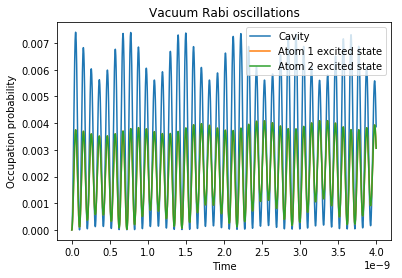

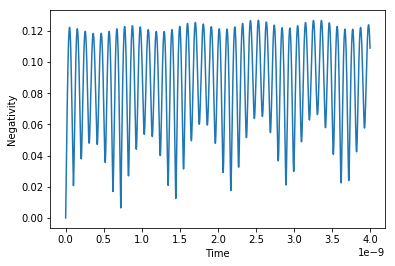

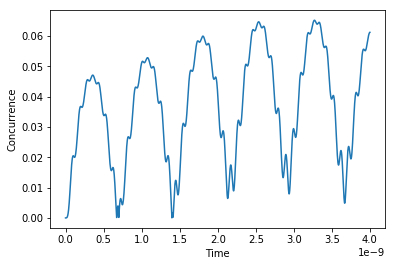

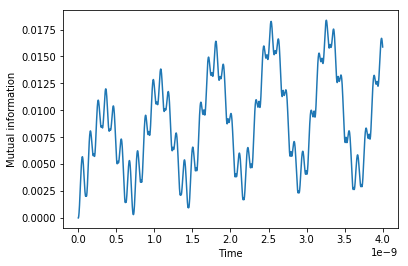

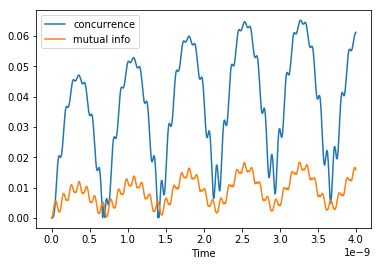

In [8]:


# intial state (ground state)
psi0 = tensor(basis(N,0), basis(2,0), basis(2,0))    # start with 0 excited atom and 0 photons



# density matrix
rho0 = ket2dm(psi0) #turns ket into a density matrix




# operators
a  = tensor(destroy(N), qeye(2), qeye(2)) #destroy cavity photon
sm1 = tensor(qeye(N), destroy(2), qeye(2)) #destroy atom1 excitation
sm2 = tensor(qeye(N), qeye(2), destroy(2)) #destroy atom2 excitation


#list of collapse operator (dissipation ops) for separate baths (for Lindblad's equation)    
c_op_list = []

rate = kappa #photon dissipation
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * a) 


rate = gamma1 #atom1 dissipation
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * sm1)
    
rate = gamma2 #atom2 dissipation
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * sm2)
    
rate = gamma_phi1 #atom1 dephasing
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * ((sm1.dag()*sm1 - qeye(1))/2) )

rate = gamma_phi2 #atom2 dephasing
if rate > 0.0:
    c_op_list.append(np.sqrt(rate) * ((sm2.dag()*sm2 - qeye(1))/2) )

    



# Rabi model Hamiltonian for two atoms and a cavity mode for time dependent coupling

def H1_coeff(t,args):
    coeff = heaviside(np.cos(20*(wc+wa)*t))
    return coeff

def H2_coeff(t,args):
    coeff = (1 - heaviside(np.cos(20*(wc+wa)*t)))*wc*(1-0.05*np.cos((wa+wa)*t) )
    return coeff

H0 =  wa*sm1.dag()*sm1 + wa*sm2.dag()*sm2 +g*(a.dag()*sm1 + a*sm1.dag() + a.dag()*sm2 + a*sm2.dag() + a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag())

H1 = wc*a.dag()*a

H2 = a.dag()*a


H = [H0,[H1,H1_coeff], [H2,H2_coeff]]



    

#solve master equation
output = mesolve(H, rho0, tau_list, c_op_list ,[a.dag() * a, sm1.dag() * sm1, sm2.dag() * sm2])  #stores expectation values of number of phontons, excitation of atom 1 and 2 

result = mesolve(H, rho0, tau_list, c_op_list)  #stores density matrix operator changing in time


# plot excitation probabilities of photons and atoms
plt.plot(tau_list, output.expect[0], label="Cavity")
plt.plot(tau_list, output.expect[1], label="Atom 1 excited state")
plt.plot(tau_list, output.expect[2], label="Atom 2 excited state")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Vacuum Rabi oscillations');
plt.show()


#initialize entanglement measures vectors
neg = np.zeros(steps) #negativity

mut = np.zeros(steps) #mutual information

conc = np.zeros(steps) #concurrence

x = [1,2] # selects the system to NOT trace over (0=photons, 1=atom1, 2=atom2)

for i in range(steps):
    states = result.states[i]*result.states[i].dag() # creates density matrix at each time 

    rhoqub = states.ptrace(x) # traces over the photonic degrees of freedom to obtain the density matrix of the qubits
    
    conc[i] = concurrence(rhoqub) # computes concurrence between qubits 
    
    mut[i] = entropy_mutual(rhoqub,0,1) #computes mutual information between the qubits
    
    neg[i] = nega(states, 1) #computes negativity between a qubit and the rest of the system
    


    
    
#plot negativity
plt.plot(tau_list,neg)
plt.xlabel('Time')
plt.ylabel('Negativity')
plt.show()    
    
#plot concurrence
plt.plot(tau_list,conc)
plt.xlabel('Time')
plt.ylabel('Concurrence')
plt.show()


#plot mutual information
plt.plot(tau_list,mut)
plt.xlabel('Time')
plt.ylabel('Mutual information')
plt.show()

#plot conc/mut
plt.plot(tau_list,conc, label = 'concurrence')
plt.plot(tau_list,mut, label = 'mutual info')
plt.xlabel('Time')
plt.legend()
plt.show()







